In [1]:
#%matplotlib widget
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker, cm
from matplotlib.ticker import LogFormatter 

from scipy.optimize import curve_fit
import copy
import os
import h5py
import json

import glob                         # Per manipolazione dei path

from collections.abc import Iterable
from Allineamento import *
import Utils
from Utils import *


In [2]:
def configurator(year,material):
    import Utils
    import json

    Utils.Swan = Swan_h
    Utils.Year = year
    Utils.Material = material
    print('SWAN ',Utils.Swan,'YEAR ',Utils.Year, material,'\n')

    ## Open config and correct offset dizionary ##

    config_file = "./config_"+ material + '_' + str(year)[2:] +".json" 
    print(config_file)

    with open(config_file, "r") as f:
                dizi = json.load(f)   
    dizi
    if (dizi['offset_y2'] == 0 or dizi['offset_x2'] == 0) & year != 00:
        input("CHECK THE ALIGNMENT, OFFSETS = 0")
    else:
        print('\noffset_x2 ', dizi['offset_x2'])
        print('offset_y2 ', dizi['offset_y2'])
    mycmap = 'jet'
    return dizi, mycmap

In [3]:
import sys 
Swan_h = ("swan" in sys.executable) or ("cern" in sys.executable)
print('Swan ', Swan_h)

## Select Year and Material ##

year = 2024
material = 'W_1.5mm'
dizi, mycmap = configurator(year,material)

import Utils
from Utils import *


Swan  True
SWAN  True YEAR  2024 W_1.5mm 

./config_W_1.5mm_24.json

offset_x2  0.001
offset_y2  0.001


In [4]:
if Swan:
    data_dir = dizi['data_path_Swan']
else:
    data_dir = dizi['data_path_local']

nRun = dizi["RunAllignment"]

data_path = f'{data_dir}/run{nRun}.h5'
print(data_path)
config_file =  "./config_"+ material + '_' + str(year)[2:] +".json" 


/eos/project/i/insulab-como/testBeam/TB_2024_06_T9_OREO/HDF5/run720734.h5


In [5]:
with h5py.File(data_path, 'r', libver='latest', swmr=True) as hf:
    print(hf.keys())
    print(hf["xpos"].shape)
    keys = list(hf.keys())
    for k in hf.keys():
        comand = f'{k} = np.array(hf["{k}"])'
        # print(comand)
        exec(comand)

logic = (xpos > -1) & (xpos < 10)
logic2 = logic.all(axis = 1)

xpos = xpos[logic2]

<KeysViewHDF5 ['digiBase', 'digiPH', 'digiTime', 'ievent', 'info_plus', 'nstrip', 'xinfo', 'xpos']>
(135149, 4)


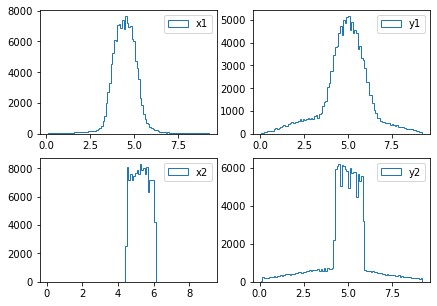

0.0008910500932733614
0.0016354514323052435


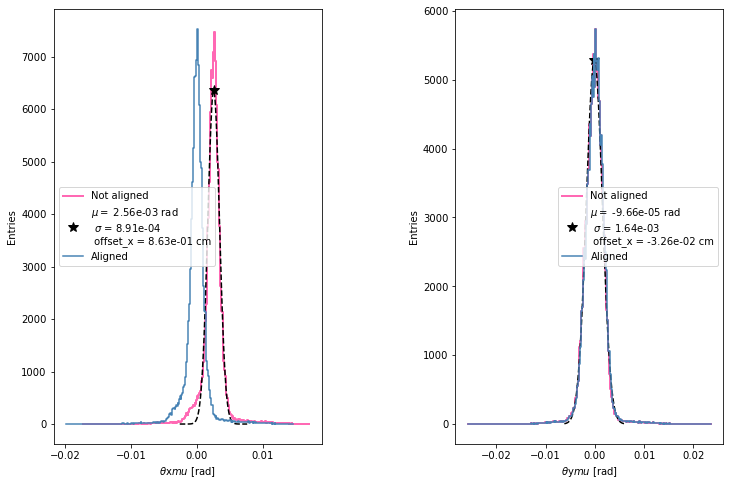

offset_x2  0.8632832537856798
offset_y2  -0.03255490631033933


In [6]:
if year == 2022:
    if material == "Diamond":
        offset12, div12 = align(xpos[:,0],xpos[:,1], xpos[:,2],xpos[:,3], dizi["d_12"], True) #DESY 22 ID Y = 1, ID X = 0
        xpos[:,2] -= offset12[0] ##23  
        xpos[:,3] -= offset12[1] ##23  
        x1 = xpos[:,0]
        y1 = xpos[:,1]
        x2 = xpos[:,2]
        y2 = xpos[:,3]
        m = 0
        q = 0
    else:
        offset12, div12 = align(xpos[:,1],xpos[:,0], xpos[:,3],xpos[:,2], dizi["d_12"], True) #PS 22 ID Y = 0, ID X = 1
        xpos[:,2] -= offset12[1] ##22
        xpos[:,3] -= offset12[0] ##22
        x1 = xpos[:,1]
        y1 = xpos[:,0]
        x2 = xpos[:,3]
        y2 = xpos[:,2]
        m = 1494
        q = 5.85
    ##x1, y1, x2, y2, d, plotter
elif year == 2023:
    ##x1, y1, x2, y2, d, plotter
    offset12, div12 = align(xpos[:,0],xpos[:,1], xpos[:,2],xpos[:,3], dizi["d_12"], True) #23 ID Y = 1, ID X = 0
    xpos[:,2] -= offset12[0] ##23  
    xpos[:,3] -= offset12[1] ##23  
    x1 = xpos[:,0]
    y1 = xpos[:,1]
    x2 = xpos[:,2]
    y2 = xpos[:,3]
    m = 1145.1773535337036
    q = -64.50218465651483
elif year == 2024:
    ##y1, x1, y2, x2, d, plotter
    offset12, div12 = align(xpos[:,1],xpos[:,0], xpos[:,3],xpos[:,2], dizi["d_12"], True) #23 ID Y = 1, ID X = 0
    xpos[:,2] -= offset12[1] ##22
    xpos[:,3] -= offset12[0] ##22
    x1 = xpos[:,1]
    y1 = xpos[:,0]
    x2 = xpos[:,3]
    y2 = xpos[:,2]

dizi['offset_x2'] = offset12[0]
dizi['offset_Y2'] = offset12[1]

dizi['div_12x'] = div12[0]
dizi['div_12y'] = div12[1]
d_tele12 = dizi['d_12']


print('offset_x2 ',offset12[0])
print('offset_y2 ', offset12[1])

#print('offset_x2 ',dizi['offset_x2'])
#print('offset_y2 ', dizi['offset_y2'])


/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:982: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/tmp/ipykernel_13512/1485225367.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(myGauss, binc, h, sigma = np.sqrt(h), absolute_sigma = True, p0 = p0)
/tmp/ipykernel_13512/1485225367.py:41: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(myGauss, binc, h, sigma = np.sqrt(h), absolute_sigma = True, p0 = p0)


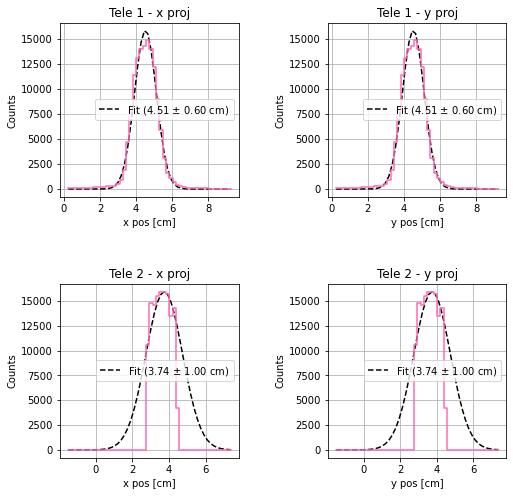

In [7]:
fig, axes = plt.subplots(2,2)
fig.subplots_adjust(wspace=.5,hspace=.5)
fig.set_size_inches(8,8)

for i in range(2):
    ax = axes[i,0]
    ax.set_title(f"Tele {i+1} - x proj")
    if year == 2022 or year ==2024:
        if material == 'Diamond':
           h, c = np.histogram(xpos[:,2*i], bins = 50) #DESY 22 ID Y = 1, ID X = 0
        else:
            h, c = np.histogram(xpos[:,2*i+1], bins = 50) #22 24 ID Y = 0, ID X = 1
    elif year == 2023:
        h, c = np.histogram(xpos[:,2*i], bins = 50) #23 ID Y = 1, ID X = 0
    
    binc = c[:-1] + (c[1]+c[0])/2
    p0 = (np.max(h), binc[np.argmax(h)],1)
    popt, pcov = curve_fit(myGauss, binc, h, sigma = np.sqrt(h), absolute_sigma = True, p0 = p0)
    
    ax.plot(binc, myGauss(binc, *popt), ls = "--", c = "k", label = f"Fit ({popt[1]:.2f} $\pm$ {popt[2]:.2f} cm)")
    
    ax.plot(binc, h, ds = 'steps-mid', c = 'hotpink')    
    # ax.set_xlim(-1,2.5)
    ax.set_xlabel("x pos [cm]")
    ax.set_ylabel("Counts")
    ax.grid()
    ax.legend()
    
    ax = axes[i,1]
    ax.set_title(f"Tele {i+1} - y proj")
    if year == 2022:
        if material == 'Diamond':
           h, c = np.histogram(xpos[:,2*i+1], bins = 50) #DESY 22 ID Y = 1, ID X = 0
        else:
            h, c = np.histogram(xpos[:,2*i], bins = 50) #22 ID Y = 0, ID X = 1
    elif year == 2023:
        h, c = np.histogram(xpos[:,2*i+1], bins = 50) #23 ID Y = 1, ID X = 0

    binc = c[:-1] + (c[1]+c[0])/2
    p0 = (np.max(h), binc[np.argmax(h)],1)
    popt, pcov = curve_fit(myGauss, binc, h, sigma = np.sqrt(h), absolute_sigma = True, p0 = p0)
    
    ax.plot(binc, myGauss(binc, *popt), ls = "--", c = "k", label = f"Fit ({popt[1]:.2f} $\pm$ {popt[2]:.2f} cm)")
    
    ax.plot(binc, h, ds = 'steps-mid', c = 'hotpink')    
    
    # ax.set_xlim(-1,2.5)
    ax.set_xlabel("y pos [cm]")
    ax.set_ylabel("Counts")
    ax.grid()
    ax.legend()
plt.show()

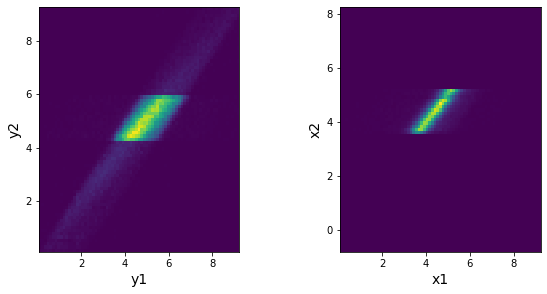

In [8]:
if year == 2022 or year ==2024:
    if material == 'Diamond':
        lstCoord = ["x1","y1","x2","y2"]
    
    else:
        lstCoord = ["y1","x1","y2","x2"]
elif year == 2023:    
    lstCoord = ["x1","y1","x2","y2"]

fig, ax = plt.subplots(1,int(len(xpos[1,:4]))-2)
fig.set_size_inches(9,4.5)
fig.subplots_adjust(wspace=.5,hspace=.5)


for i in range(int(len(xpos[0,:4]))-2):
    # print(f'{i+1}-{(len(xpos[1,:]))}')
    if i <= 3:
        ax[i].hist2d(xpos[:,i],xpos[:,i+2],bins=75)
        ax[i].set_xlabel(lstCoord[i],fontsize = 14)
        ax[i].set_ylabel(lstCoord[i+2], fontsize = 14)   
plt.show()

In [9]:
if material == "Diamond":
    num_bins = 100
    range_h =  [[-5,5],[0,10000]]
    fig, ax = plt.subplots(2,3)
    fig.set_size_inches(9,4)
    fig.subplots_adjust(wspace=.5,hspace=.5)

    listChans = [2,3,4,5,6,7,8,9,11]
    Calo = np.sum(digiPH[:, listChans], axis = 1)
    Calo = Calo[logic2]
    x_calo,y_calo= projectDistZ3(xpos[:,0],xpos[:,1],0,xpos[:,2],xpos[:,3],789,(789+1001.5+5876+85+697))

    print(np.shape(x_calo)) 
    print(np.shape(Calo)) 

    ax[0,0].hist2d(x_calo,Calo,bins = num_bins, range = range_h)    
    ax[0,0].set_xlabel('x_calo')
    ax[0,0].set_ylabel('Ph_calo')
    ax[1,0].hist2d(y_calo,Calo,bins = num_bins, range = range_h)    
    ax[1,0].set_xlabel('y_calo')
    ax[1,0].set_ylabel('Ph_calo')

    ax[0,1].hist2d(x1,Calo,bins = num_bins, range = range_h)    
    ax[0,1].set_xlabel('x1')
    ax[0,1].set_ylabel('Ph_calo')
    ax[1,1].hist2d(y1,Calo,bins = num_bins, range = range_h)    
    ax[1,1].set_xlabel('y1')
    ax[1,1].set_ylabel('Ph_calo')
    
    ax[0,2].hist2d(x2,Calo,bins = num_bins, range = range_h)    
    ax[0,2].set_xlabel('x2')
    ax[0,2].set_ylabel('Ph_calo')
    ax[1,2].hist2d(y2,Calo,bins = num_bins, range = range_h)    
    ax[1,2].set_xlabel('y2')
    ax[1,2].set_ylabel('Ph_calo')
    plt.show()

In [10]:
'''dist_chambers = d_tele12

deltaX = x2-x1 # tele 2-1 
#print('deltaX',deltaX)
deltaY = y2-y1
#print('deltaY',deltaY)

theta_12_x = np.arctan(deltaX/dist_chambers) * 1e6 # urad
theta_12_y = np.arctan(deltaY/dist_chambers) * 1e6 # urad

#print('theta_12_x', theta_12_x, '\n', 'theta_12_y', theta_12_y)

theta12 = [theta_12_x, theta_12_y]
thetaLbl = ["x", "y"]
num_bins = 100
range_hist = [[-5000,5000],[-5000,5000]]

fig, ax = plt.subplots(1,2)

fig.set_size_inches(9,5)
plt.subplots_adjust(hspace=0.5,wspace =0.3) 

titles = [fr"$\theta_X in 12$ ", fr"$\theta_Y in12 $"]
divs = []
popt_list12 =[]
for i in range(2):
    h, bins = np.histogram(theta12[i], bins = num_bins)#, range=range_hist[i] )
    #print(h)
    binc = bins[:-1] + (bins[1] - bins[0]) / 2
    #print(binc)
    p0 = (np.max(h), binc[np.argmax(h)], np.std(binc))
    cond = (h>0) 
    popt, pcov = curve_fit(Gauss, binc[cond], h[cond], sigma = np.sqrt(h[cond]), absolute_sigma = True, p0 = p0)
    popt_list12.append(popt[1])
    ax[i].plot(binc, h, ds = "steps-mid", c = "hotpink", lw = .7,
               label = fr"$\theta_{thetaLbl[i]}$")
    
    ax[i].plot(binc, myGauss(binc, *popt), ls = "--", c = "k", label = f"Fit ({popt[1]:.2f} $\pm$ {popt[2]:.2f} urad)")
    
    ax[i].grid()
    ax[i].set_title(titles[i])
    ax[i].set_ylabel("Entries", fontsize = 10)    
    ax[i].set_xlabel(r"$\theta$ [urad]",fontsize = 10)

    ax[i].legend(fontsize = 10)
    divs.append(popt[2])
    print(f"La divergenza in {thetaLbl[i]} vale {popt[2]:.2f} urad")

plt.show()
# Creazione del plot
fig, ax = plt.subplots()
fig.set_size_inches(9,5)
ax.hist2d(theta12[0], theta12[1], bins=num_bins)#, range = range_hist)

# Etichette degli assi
ax.grid()
ax.set_xlabel('thetax')
ax.set_ylabel('thetay')
        
plt.show()
print(divs)

with open(config_file, "r") as file:
        config_data = json.load(file)
    
config_data['div_x'] = divs[0]
config_data['div_y'] = divs[1]
    
    
with open(config_file, "w") as file:
    json.dump(config_data, file, indent=4)'''


'dist_chambers = d_tele12\n\ndeltaX = x2-x1 # tele 2-1 \n#print(\'deltaX\',deltaX)\ndeltaY = y2-y1\n#print(\'deltaY\',deltaY)\n\ntheta_12_x = np.arctan(deltaX/dist_chambers) * 1e6 # urad\ntheta_12_y = np.arctan(deltaY/dist_chambers) * 1e6 # urad\n\n#print(\'theta_12_x\', theta_12_x, \'\n\', \'theta_12_y\', theta_12_y)\n\ntheta12 = [theta_12_x, theta_12_y]\nthetaLbl = ["x", "y"]\nnum_bins = 100\nrange_hist = [[-5000,5000],[-5000,5000]]\n\nfig, ax = plt.subplots(1,2)\n\nfig.set_size_inches(9,5)\nplt.subplots_adjust(hspace=0.5,wspace =0.3) \n\ntitles = [fr"$\theta_X in 12$ ", fr"$\theta_Y in12 $"]\ndivs = []\npopt_list12 =[]\nfor i in range(2):\n    h, bins = np.histogram(theta12[i], bins = num_bins)#, range=range_hist[i] )\n    #print(h)\n    binc = bins[:-1] + (bins[1] - bins[0]) / 2\n    #print(binc)\n    p0 = (np.max(h), binc[np.argmax(h)], np.std(binc))\n    cond = (h>0) \n    popt, pcov = curve_fit(Gauss, binc[cond], h[cond], sigma = np.sqrt(h[cond]), absolute_sigma = True, p0 = p0)

In [11]:
dizi

{'RunAllignment': 720734,
 'd_12': 337,
 'd_1c': 370,
 'd_cM': 1.41,
 'thM': 0.4,
 'd_MLG': 631,
 'offset_x2': 0.8632832537856798,
 'offset_y2': 0.001,
 'div_12x': 0.0008910500932733614,
 'div_12y': 0.0016354514323052435,
 'slope_Calo': 202,
 'intercept_Calo': -37,
 'data_path_Swan': '/eos/project/i/insulab-como/testBeam/TB_2024_06_T9_OREO/HDF5',
 'data_path_local': './data/TB_T9_2024',
 'r_random': [],
 'r_axial': [],
 'r_scan': [[], [], [], []],
 'scan_labels': ['random', 'axial', '', '', ''],
 'n_bin_calo': 500,
 'n_bin_APC1': 500,
 'n_bin_APC2': 500,
 'Calo_th': 500,
 'APC1_th': 75,
 'APC2_th': 75,
 'Pos_X': [3.5, 4.5],
 'Pos_Y': [3.5, 4.5],
 'logi_time': [91, 98],
 'cut_calo': [0, 0],
 'cut_calo_calib': [0.8, 0.8],
 'cut_APC': [75, 100],
 'div_x': 800.9851198717129,
 'div_y': 1509.4875827334101,
 'offset_Y2': -0.03255490631033933}